In [ ]:
from env_utils import get_envs
import numpy as np
from env_utils import initialize_envs, close_envs

In [ ]:
arg_dict = {}
arg_dict["env"] = "CartpoleSwingup"
arg_dict["dim_in"] = 6
arg_dict["dim_out"] = 4
arg_dict["dim_states"] = 4
arg_dict["dim_actions"] = 1
arg_dict["dim_angles"] = 1
arg_dict["target_reward"] = -0.08

In [ ]:
arg_dict = {}
arg_dict["env"] = "PendulumEnv"
arg_dict["dim_in"] = 4
arg_dict["dim_out"] = 2
arg_dict["dim_states"] = 2
arg_dict["dim_actions"] = 1
arg_dict["dim_angles"] = 1
arg_dict["target_reward"] = -0.08

In [ ]:
training_envs, test_envs = get_envs(**arg_dict)

In [ ]:
training_envs

In [ ]:
seed = 1
envs = initialize_envs(training_envs, seed)

In [ ]:
envs

In [ ]:
env1 = envs[0]

In [ ]:
print("action space high: ", env1.action_space.high)
print("action space low: ", env1.action_space.low)

In [ ]:

def anylize_env(env, test_episodes = 200,max_episode_step = 1000, render = False):
    print("state space shape: ", env.observation_space.shape)
    print("state space lower bound: ", env.observation_space.low)
    print("state space upper bound: ", env.observation_space.high)
    print("action space shape: ", env.action_space.shape)
    print("action space lower bound: ", env.action_space.low)
    print("action space upper bound: ", env.action_space.high)
    print("reward range: ", env.reward_range)
    rewards = []
    steps = []
    for episode in range(test_episodes):
        env.reset()
        step = 0
        episode_reward = 0
        for _ in range(max_episode_step):
            if render:
                env.render()
            step += 1
            action = env.action_space.sample()
            state, reward,done,_= env.step(action)
            episode_reward += reward
            if done:
               # print("done with step: %s " % (step))
                break
        steps.append(step)
        rewards.append(episode_reward)
    env.close()
    print("Randomly sample actions for %s episodes, with maximum %s steps per episodes"
          % (test_episodes, max_episode_step))
    print(" average reward per episode: %s, std: %s " % (np.mean(rewards), np.std(rewards) ))
    print(" average steps per episode: ", np.mean(steps))
    print(" average reward per step: ", np.sum(rewards)/np.sum(steps))

In [ ]:
actions = np.random.randint(4,8,size=(4,8))
actions

In [ ]:
(actions-1)%5

In [ ]:
action_batch = actions[:,0].reshape(-1,1)

In [ ]:
state_batch = np.repeat(state.reshape(1,-1), 4, axis=0)

In [ ]:
state_batch = torch.tensor(state_batch).float()
action_batch = torch.tensor(action_batch).float()

In [ ]:
state_batch.shape

In [1]:
import numpy as np
import scipy.stats as stats
import torch
import matplotlib.pyplot as plt
import time
from torch.nn import init
import math

In [2]:
def parameterized_truncated_normal(uniform, mu, sigma, a, b):
    normal = torch.distributions.normal.Normal(0, 1)

    alpha = (a - mu) / sigma
    beta = (b - mu) / sigma

    alpha_normal_cdf = normal.cdf(alpha)
    p = alpha_normal_cdf + (normal.cdf(beta) - alpha_normal_cdf) * uniform

    p = p.numpy()
    one = np.array(1, dtype=p.dtype)
    epsilon = np.array(np.finfo(p.dtype).eps, dtype=p.dtype)
    v = np.clip(2 * p - 1, -one + epsilon, one - epsilon)
    x = mu + sigma * np.sqrt(2) * torch.erfinv(torch.from_numpy(v))
    x = torch.clamp(x, a[0], b[0])
    return x

def sample_truncated_normal(shape=(), mu=0.0, sigma=1.0, a=-2, b=2):
    #uni = torch.from_numpy(np.random.uniform(0, 1, shape))
    uni = torch.rand(shape)
    return parameterized_truncated_normal(uni, mu=mu, sigma=sigma, a=a, b=b)

In [22]:
init_mean = np.array([0,1,2,3])
init_var = np.array([1,4,2,3])
lb = -4
ub = 8
popsize = 100000
sol_dim = 4

0.013004064559936523


(100000, 4)

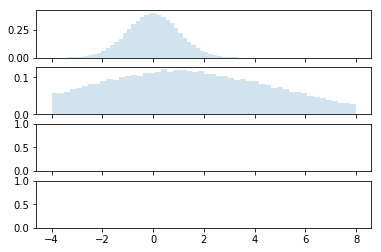

In [29]:
t = time.time()
mean, var = init_mean, init_var
a, b = torch.tensor([lb]*sol_dim), torch.tensor([ub]*sol_dim)
size = [popsize,sol_dim]
lb_dist, ub_dist = mean - lb, ub - mean
constrained_var = np.minimum(np.minimum(np.square(lb_dist / 2), np.square(ub_dist / 2)), var)
#constrained_var = np.sqrt(constrained_var)
mu= torch.tensor(mean)
sigma = torch.tensor(constrained_var)
r1 = sample_truncated_normal(size, mu, sigma, a, b).numpy()
print(time.time()-t)

fig, axs = plt.subplots(sol_dim,sharex=True)
for i in range(2):
    axs[i].hist(r1[:, i], density=True, histtype='stepfilled', alpha=0.2, bins=50)

r1.shape

1.7296907901763916


10.434859241506533

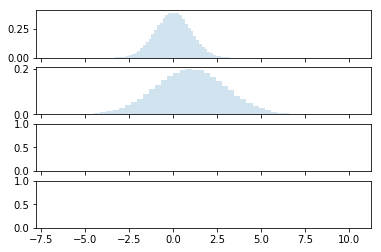

In [30]:
mean, var = init_mean, init_var
t = time.time()
X = stats.truncnorm(lb, ub, loc=np.zeros_like(mean), scale=np.ones_like(mean))
lb_dist, ub_dist = mean - lb, ub - mean
constrained_var = np.minimum(np.minimum(np.square(lb_dist / 2), np.square(ub_dist / 2)), var)
r = X.rvs(size=[popsize, sol_dim]) * np.sqrt(constrained_var) + mean
print(time.time()-t)

fig, axs = plt.subplots(sol_dim,sharex=True)
for i in range(2):
    axs[i].hist(r[:, i], density=True, histtype='stepfilled', alpha=0.2, bins=50)

r.max()

(100000, 4)

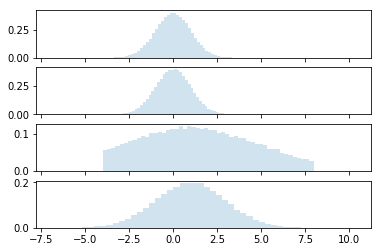

In [31]:
fig, axs = plt.subplots(4,sharex=True)

axs[0].hist(r1[:, 0], density=True, histtype='stepfilled', alpha=0.2, bins=50)
axs[1].hist(r[:, 0], density=True, histtype='stepfilled', alpha=0.2, bins=50)
axs[2].hist(r1[:, 1], density=True, histtype='stepfilled', alpha=0.2, bins=50)
axs[3].hist(r[:, 1], density=True, histtype='stepfilled', alpha=0.2, bins=50)
r.shape

In [32]:
samples = X.rvs(size=[popsize, sol_dim]) * np.sqrt(constrained_var) + mean

In [ ]:
while (t < self.max_iters) and np.max(var) > self.epsilon:
    lb_dist, ub_dist = mean - self.lb, self.ub - mean
    constrained_var = np.minimum(np.minimum(np.square(lb_dist / 2), np.square(ub_dist / 2)), var)

    samples = X.rvs(size=[self.popsize, self.sol_dim]) * np.sqrt(constrained_var) + mean
    costs = self.cost_function(samples)
    elites = samples[np.argsort(costs)][:self.num_elites]

    new_mean = np.mean(elites, axis=0)
    new_var = np.var(elites, axis=0)

    mean = self.alpha * mean + (1 - self.alpha) * new_mean
    var = self.alpha * var + (1 - self.alpha) * new_var

    t += 1
sol, solvar = mean, var

In [ ]:
torch.min()

In [ ]:

mean = np.array([-0.5,0.5])
var = np.array([1,1])
lb, ub = -1, 1
a, b = (lb-init_mean)/init_var, (ub-init_mean)/init_var 
popsize, sol_dim = 100000, 2
X = stats.truncnorm(a, b, loc=init_mean, scale=init_var)
lb_dist, ub_dist = mean - lb, ub - mean
constrained_var = np.minimum(np.minimum(np.square(lb_dist / 2), np.square(ub_dist / 2)), var)

t = time.time()
r = X.rvs(size=[popsize, sol_dim]) 
print(time.time()-t)
plt.hist(r[:,1], density=True, histtype='stepfilled', alpha=0.2, bins=50)
r.shape

In [ ]:
plt.hist(samples[:,2])